In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 13

##### Load Data

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../dataset',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['potato_early_blight', 'potato_healthy', 'potato_late_blight']

##### Data Visualization

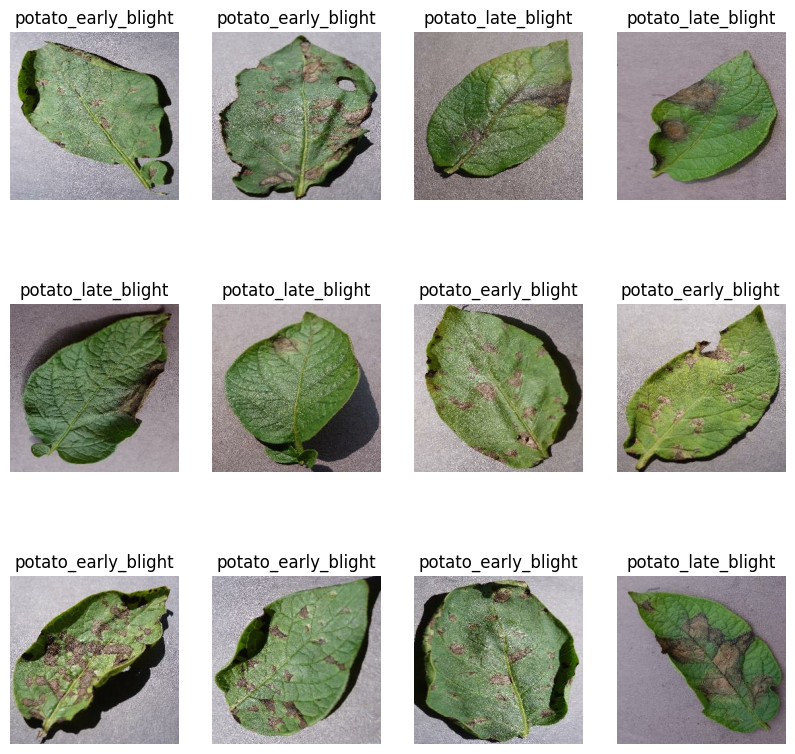

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('Off')

In [6]:
len(dataset)

68

##### Split Dataset

In [7]:
count_images = len(dataset)
train_size = int(count_images*0.8)

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

test_size = int(len(test_ds)*0.5)

validation_ds = test_ds.take(test_size)
test_ds = test_ds.skip(test_size)

##### Function to Split Dataset

In [8]:
def get_data_partition(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_data_partition(dataset)

In [10]:
print(len(train_ds),len(val_ds),len(test_ds))

54 6 8


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

##### Data Augmentation

In [12]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#### Build and Train CNN Model

##### Model Architecture

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [16]:
model.compile(
    optimizer = 'Adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/13
54/54 [==============================] - 63s 1s/step - loss: 0.8985 - accuracy: 0.4647 - val_loss: 0.9274 - val_accuracy: 0.4688
Epoch 2/13
54/54 [==============================] - 56s 1s/step - loss: 0.5562 - accuracy: 0.7882 - val_loss: 0.5769 - val_accuracy: 0.7969
Epoch 3/13
54/54 [==============================] - 54s 1s/step - loss: 0.4200 - accuracy: 0.8455 - val_loss: 0.9309 - val_accuracy: 0.7031
Epoch 4/13
54/54 [==============================] - 52s 966ms/step - loss: 0.3562 - accuracy: 0.8704 - val_loss: 0.2599 - val_accuracy: 0.8958
Epoch 5/13
54/54 [==============================] - 52s 967ms/step - loss: 0.2547 - accuracy: 0.9091 - val_loss: 0.1916 - val_accuracy: 0.9479
Epoch 6/13
54/54 [==============================] - 52s 961ms/step - loss: 0.1901 - accuracy: 0.9346 - val_loss: 0.3125 - val_accuracy: 0.8854
Epoch 7/13
54/54 [==============================] - 54s 998ms/step - loss: 0.1559 - accuracy: 0.9387 - val_loss: 0.3569 - val_accuracy: 0.8646
Epoch 8/

In [18]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 237ms/step - loss: 0.1258 - accuracy: 0.9414


In [19]:
scores

[0.1258055865764618, 0.94140625]

In [20]:
history.params

{'verbose': 1, 'epochs': 13, 'steps': 54}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

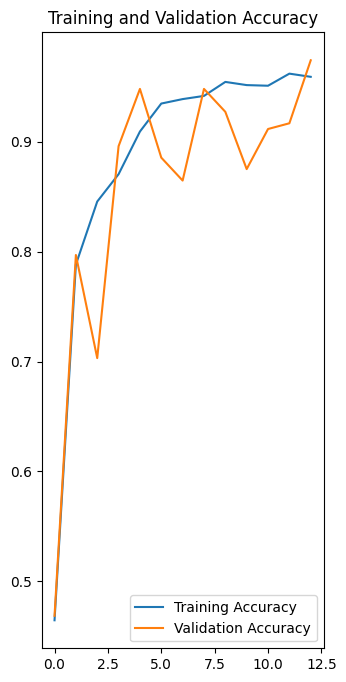

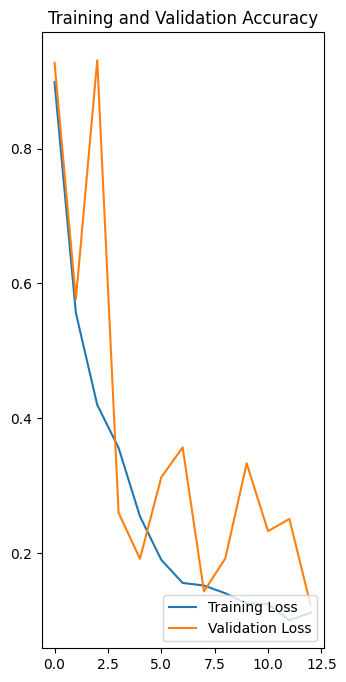

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

First Image to Predict
Actual Label:  potato_late_blight
1/1 [==============================] - 0s 407ms/step
potato_late_blight


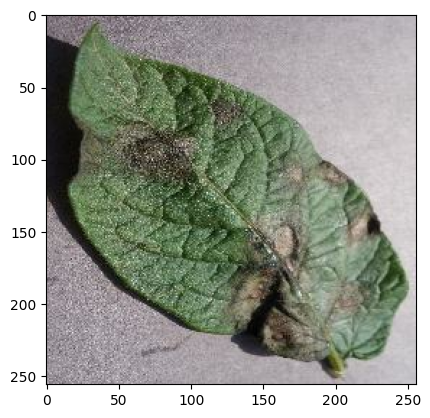

In [24]:
for images_batch, labels_batch in train_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First Image to Predict')
    plt.imshow(first_image)
    print('Actual Label: ', class_names[first_label])
    
    image_predict = model.predict(images_batch)
    print(class_names[np.argmax(image_predict[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


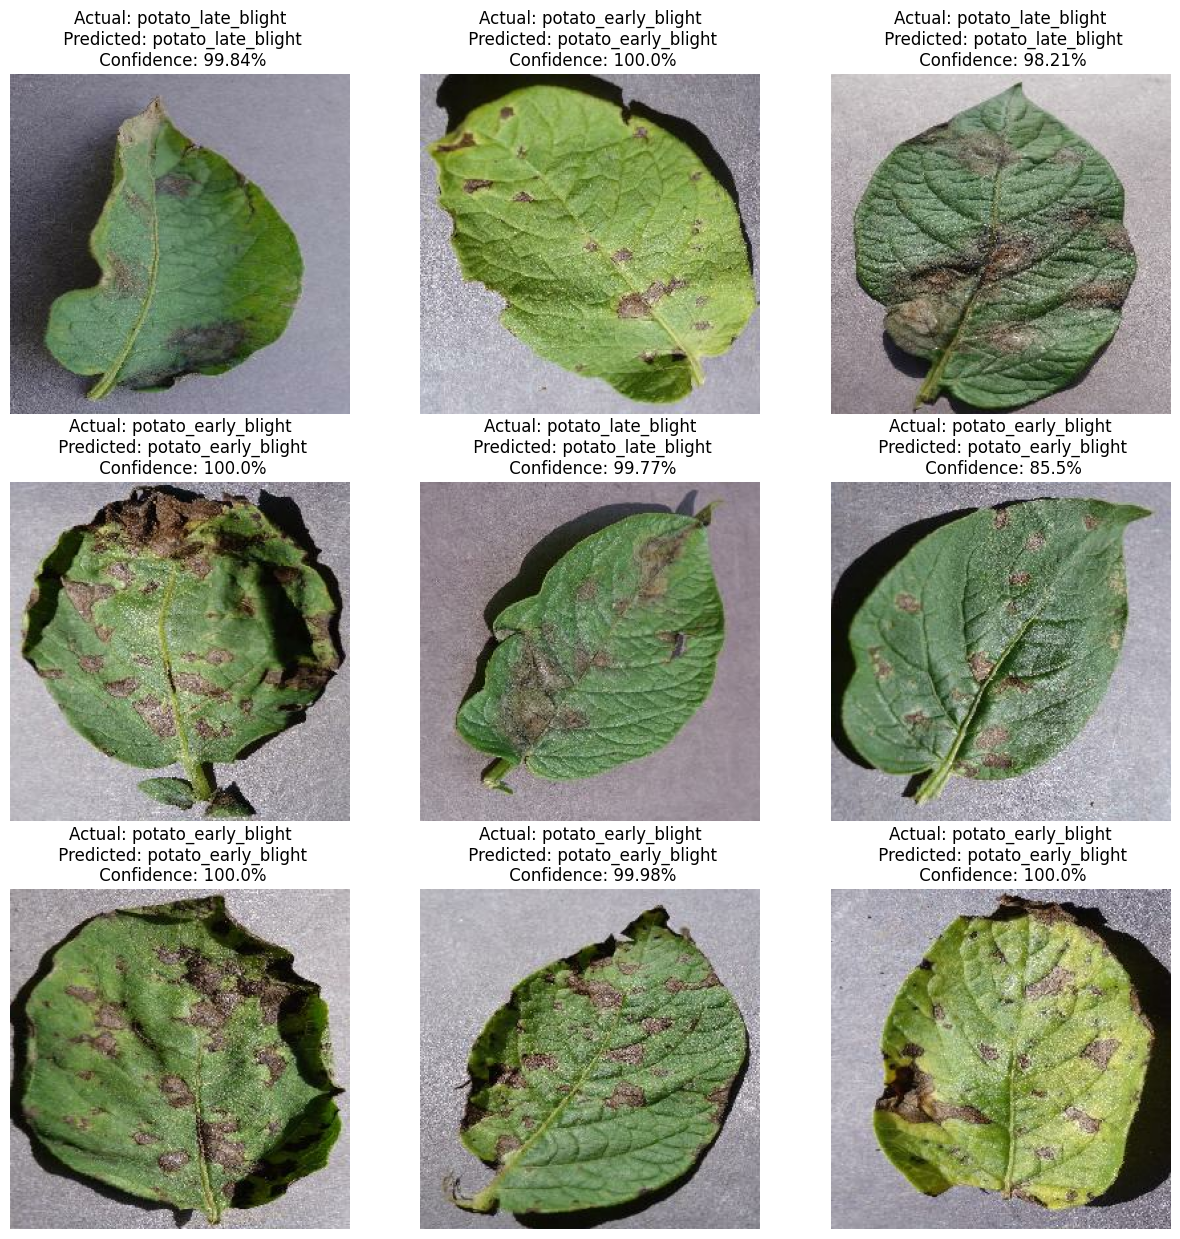

In [26]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]
        
        plt.title(f'Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}%')
        
        plt.axis('off')

In [27]:
import os
model_version = max([float(i) for i in os.listdir('../models/') +[0]])+1
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ../models/3.0\assets


INFO:tensorflow:Assets written to: ../models/3.0\assets
